####
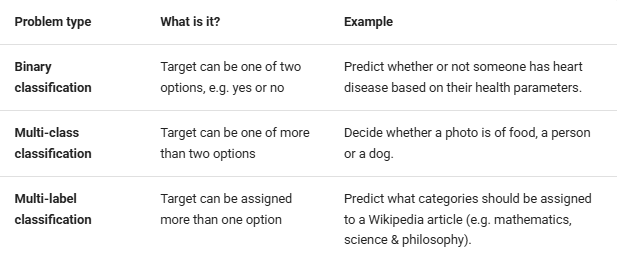

#### 0. Architecture of a classification neural network
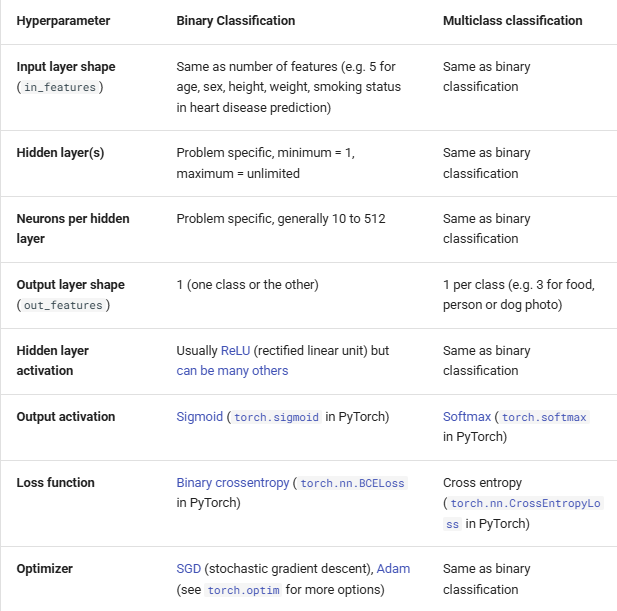

In [40]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [41]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1" : X[:, 0], 
                        "X2" : X[:, 1],
                        "label" : y})
circles.head(5)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [42]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

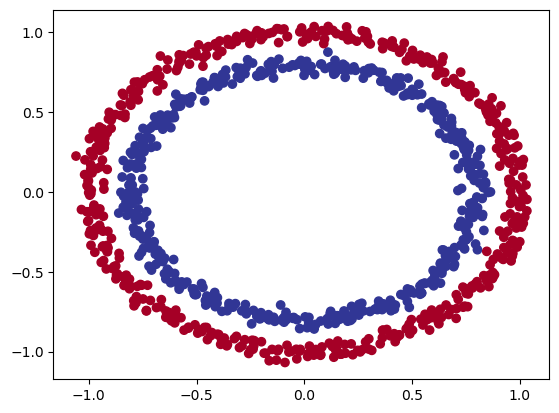

In [43]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

#### 1.1 Input and output shapes

In [44]:
# Check the shapes of our features and labels
print(X.shape, y.shape)

X_sample = X[0]
y_sample = y[0]
print(X_sample, y_sample)

(1000, 2) (1000,)
[0.75424625 0.23148074] 1


#### 1.2 Turn data into tensors and create train and test splits

In [45]:
# Turn data into tensors
# Other wise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [46]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

#### 2. Building a model

In [47]:
# Standard Pytorch Imports
import torch
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [48]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

        # Define a forward method containing the forward pass computation
        def forward(self, x):
            # Return the output of layer_2, a single fearure, the same shape as y
            return self.layer_2(self.layer_1(x)) # layer_1 -> layer_2
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [49]:
# Repicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [50]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


#### 2.1 Setup loss function and optimizer
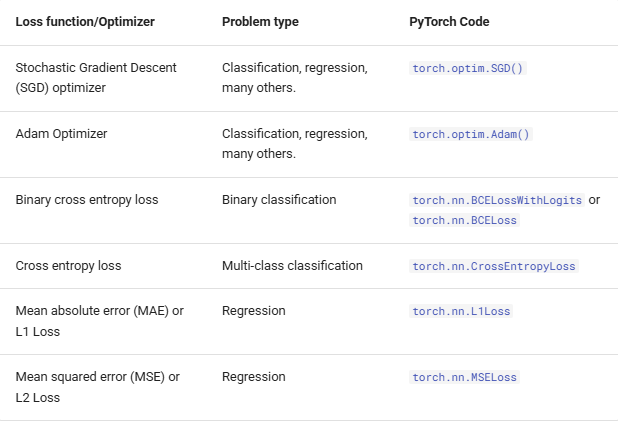

In [51]:
# Create a loss function 
# loss_fn = nn.ECELoss() -> no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [52]:
# Calclulate accuracy 
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

#### 3. Train model

In [53]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0', grad_fn=<SliceBackward0>)

#### 3.1 Going from raw model outputs to predicted labels 
     (logits -> prediction probabilities -> prediction labels)

In [54]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [55]:
# Find the predicted labels (round the prediction prebabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equlity
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
print(y_preds.squeeze())


tensor([True, True, True, True, True], device='cuda:0')
tensor([0., 0., 1., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)


#### Building a training and testing loop

In [56]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Foward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer Zero grad
    optimizer.zero_grad()

    # 4. Loss bkackwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ## Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print("Epoch : {} | Loss : {:.5f} | Accuracy : {:.2f} | Test loss {:.5f} | Test acc {:.2f}".format(epoch, loss, acc, test_loss, test_acc))

Epoch : 0 | Loss : 0.69796 | Accuracy : 51.88 | Test loss 0.69440 | Test acc 58.00
Epoch : 10 | Loss : 0.69590 | Accuracy : 51.25 | Test loss 0.69305 | Test acc 53.00
Epoch : 20 | Loss : 0.69490 | Accuracy : 51.62 | Test loss 0.69254 | Test acc 49.50
Epoch : 30 | Loss : 0.69435 | Accuracy : 51.12 | Test loss 0.69236 | Test acc 49.50
Epoch : 40 | Loss : 0.69401 | Accuracy : 50.88 | Test loss 0.69232 | Test acc 51.00
Epoch : 50 | Loss : 0.69378 | Accuracy : 50.25 | Test loss 0.69234 | Test acc 50.00
Epoch : 60 | Loss : 0.69362 | Accuracy : 50.00 | Test loss 0.69239 | Test acc 51.50
Epoch : 70 | Loss : 0.69351 | Accuracy : 50.25 | Test loss 0.69246 | Test acc 51.00
Epoch : 80 | Loss : 0.69342 | Accuracy : 49.88 | Test loss 0.69254 | Test acc 50.00
Epoch : 90 | Loss : 0.69336 | Accuracy : 49.88 | Test loss 0.69262 | Test acc 53.00


#### 4. Make predictions and evaluate the model

In [57]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


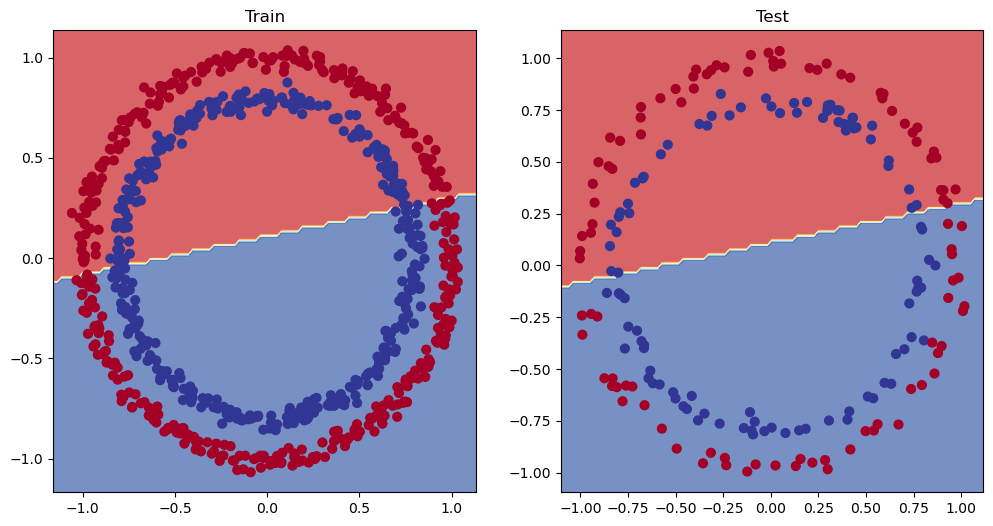

In [58]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)